In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 66.7 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Loaded From: /content/resume_data/UpdatedResumeDataSet.csv


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


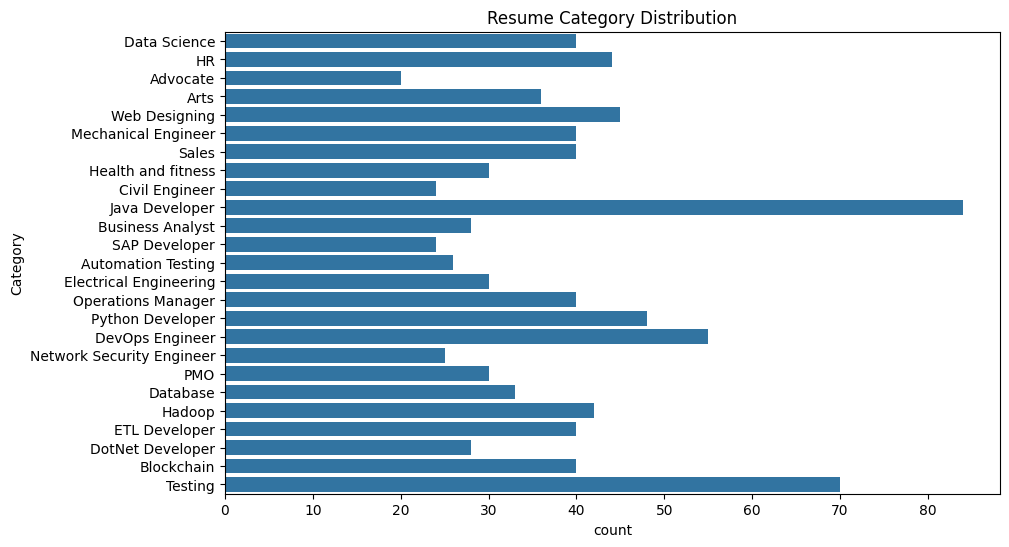

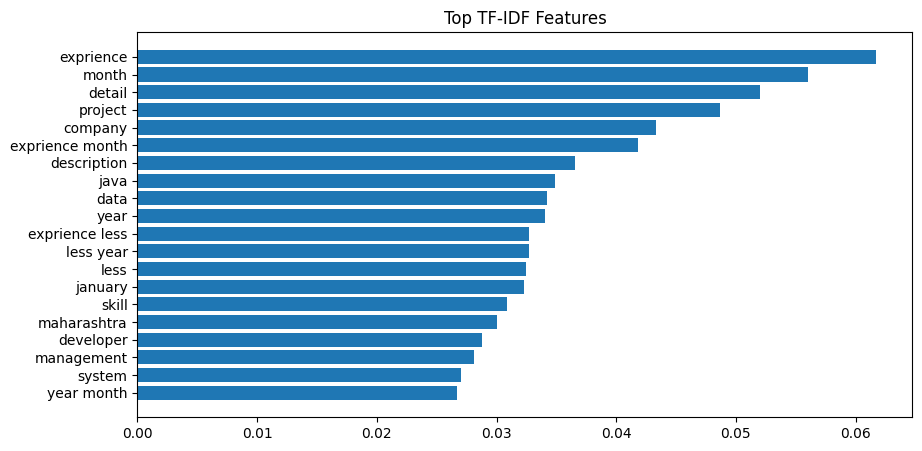

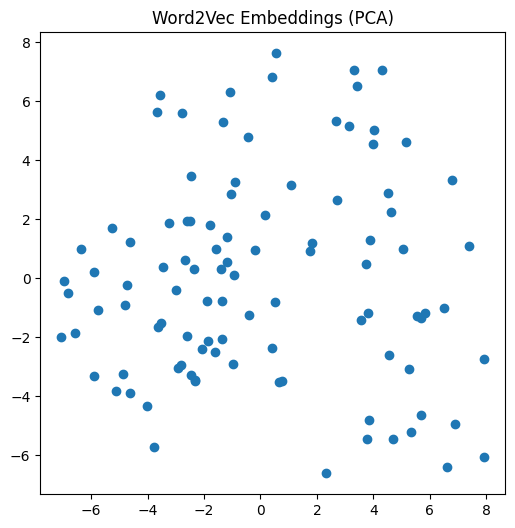

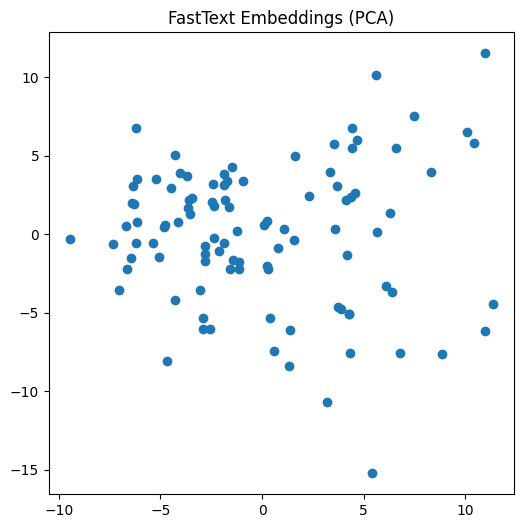

Accuracy: 0.9948186528497409

Classification Report:

                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         4
                     Arts       1.00      1.00      1.00         7
       Automation Testing       0.83      1.00      0.91         5
               Blockchain       1.00      1.00      1.00         8
         Business Analyst       1.00      1.00      1.00         6
           Civil Engineer       1.00      1.00      1.00         5
             Data Science       1.00      1.00      1.00         8
                 Database       1.00      1.00      1.00         7
          DevOps Engineer       1.00      0.91      0.95        11
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         8
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      1.00      1.00         9
       

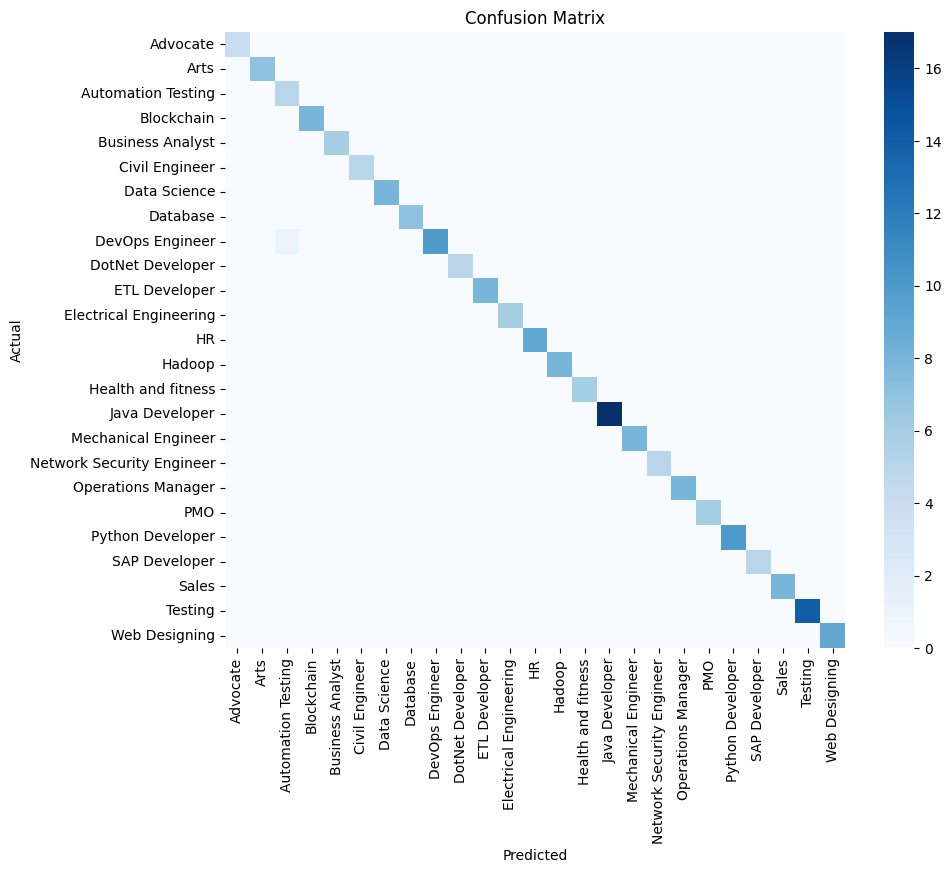

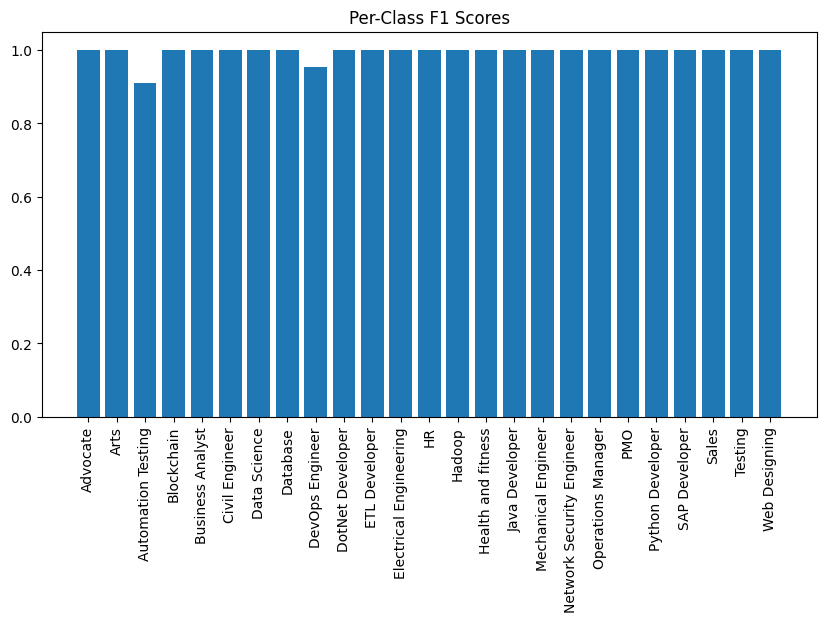

In [ ]:
# =====================================================
# INSTALL REQUIRED LIBRARIES
# =====================================================
!pip install -q gensim nltk matplotlib seaborn scikit-learn

# =====================================================
# MOUNT GOOGLE DRIVE
# =====================================================
from google.colab import drive
drive.mount('/content/drive')

# =====================================================
# EXTRACT DATASET ZIP
# =====================================================
import zipfile, os

zip_path = "/content/drive/MyDrive/Colab Notebooks/archive.zip"
extract_path = "/content/resume_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Find CSV file automatically
csv_file = None
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith(".csv"):
            csv_file = os.path.join(root, file)

print("Dataset Loaded From:", csv_file)

# =====================================================
# IMPORT LIBRARIES
# =====================================================
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

from gensim.models import Word2Vec, FastText
from sklearn.decomposition import PCA

# =====================================================
# DOWNLOAD NLTK DATA
# =====================================================
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# =====================================================
# LOAD DATASET
# =====================================================
df = pd.read_csv(csv_file)

# =====================================================
# EDA – CATEGORY DISTRIBUTION
# =====================================================
plt.figure(figsize=(10,6))
sns.countplot(y=df["Category"])
plt.title("Resume Category Distribution")
plt.show()

# =====================================================
# TASK 3: TEXT PREPROCESSING
# =====================================================
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z ]', ' ', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df["clean_resume"] = df["Resume"].apply(clean_text)

# =====================================================
# LABEL ENCODING
# =====================================================
le = LabelEncoder()
df["label"] = le.fit_transform(df["Category"])

# =====================================================
# TRAIN-TEST SPLIT
# =====================================================
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_resume"],
    df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

# =====================================================
# TASK 4: TF-IDF REPRESENTATION
# =====================================================
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# TF-IDF TOP TERMS
feature_names = tfidf.get_feature_names_out()
tfidf_scores = np.asarray(X_train_tfidf.mean(axis=0)).flatten()
top_idx = tfidf_scores.argsort()[-20:]

plt.figure(figsize=(10,5))
plt.barh(feature_names[top_idx], tfidf_scores[top_idx])
plt.title("Top TF-IDF Features")
plt.show()

# =====================================================
# TASK 5: EMBEDDINGS – WORD2VEC & FASTTEXT
# =====================================================
tokenized_text = [text.split() for text in X_train]

w2v = Word2Vec(tokenized_text, vector_size=100, window=5, min_count=2)
ft = FastText(tokenized_text, vector_size=100, window=5, min_count=2)

def plot_embedding(model, title):
    words = model.wv.index_to_key[:100]
    vectors = np.array([model.wv[w] for w in words])
    reduced = PCA(n_components=2).fit_transform(vectors)

    plt.figure(figsize=(6,6))
    plt.scatter(reduced[:,0], reduced[:,1])
    plt.title(title)
    plt.show()

plot_embedding(w2v, "Word2Vec Embeddings (PCA)")
plot_embedding(ft, "FastText Embeddings (PCA)")

# =====================================================
# TASK 6: MODEL DEFINITION
# =====================================================
model = LinearSVC(class_weight="balanced", max_iter=3000)

# =====================================================
# TASK 7: MODEL TRAINING
# =====================================================
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

# =====================================================
# EVALUATION METRICS
# =====================================================
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# PER-CLASS F1 SCORE
f1 = f1_score(y_test, y_pred, average=None)
plt.figure(figsize=(10,5))
plt.bar(le.classes_, f1)
plt.xticks(rotation=90)
plt.title("Per-Class F1 Scores")
plt.show()


In [ ]:
# =====================================================
# INSTALL & IMPORT GRADIO (COLAB SAFE)
# =====================================================
!pip install -q gradio

import gradio as gr

# =====================================================
# PREDICTION FUNCTION
# =====================================================
def predict_resume(resume_text):
    if resume_text is None or resume_text.strip() == "":
        return "⚠️ Please paste resume text."

    cleaned = clean_text(resume_text)
    vector = tfidf.transform([cleaned])
    pred = model.predict(vector)[0]

    return f"✅ Predicted Job Category: {le.inverse_transform([pred])[0]}"

# =====================================================
# GRADIO INTERFACE
# =====================================================
interface = gr.Interface(
    fn=predict_resume,
    inputs=gr.Textbox(
        lines=12,
        placeholder="Paste resume text here..."
    ),
    outputs=gr.Textbox(),
    title="Resume Classification System",
    description="Paste a resume to predict the job category using NLP + SVM"
)

# =====================================================
# LAUNCH PUBLIC GRADIO LINK
# =====================================================
interface.launch(
    share=True,
    debug=False
)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://772f891f602afed8c5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
